# Exercise 2.9

Create and plot a GeoDataFrame with the top 1% and the bottom 1% municipalities in Italy based on their area
* Download a shapefile that describe Italian regions (e.g., [here](https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_ITA_shp.zip))
* Create a GeoDataFrame with two rows (top 1% and bottom 1%) and the corresponding multipolygons
* Plot the multipolygons with folium
* Submit a (well-documented) notebook

## Installing the packages

In [ ]:
# correct order to avoid errors
!pip install Shapely
!pip install folium
!pip install Fiona
!pip install pyproj
!pip install rtree
!pip install pygeos
!pip install scikit-mobility
!pip install -U geopandas #scikit mobilty force the installation of geopandas 0.9 for compatibiltiy but that version doesn't have some features as "sjoin" from geopandas
!pip install geovoronoi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 6.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 8.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 8.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 8.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 9.1 MB/s 
     |███████████████

## Importing Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np

import skmob
import folium
import random

#to download and extract the shape files
import urllib.request
import zipfile
import os

#to perform the union of the two sets of bottom and top 1%
from shapely.ops import unary_union

In [2]:
file_name = 'gadm41_ITA_shp.zip'

#downloading a shp with the italian regions
urllib.request.urlretrieve('https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_ITA_shp.zip', file_name)

#extracting the zipped files
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall()
#removing the zip
os.remove(file_name)

#getting the shp files from the directory
shape_files = [x for x in os.listdir() if x[-3:] == 'shp']
print(shape_files)

['gadm41_ITA_0.shp', 'gadm41_ITA_1.shp', 'gadm41_ITA_2.shp', 'gadm41_ITA_3.shp']


In [3]:
#after a rapid check I divided the shape files for each administrative subdivision
regions = gpd.read_file('gadm41_ITA_1.shp')
provinces = gpd.read_file('gadm41_ITA_2.shp')
municipalities = gpd.read_file('gadm41_ITA_3.shp')
italy = gpd.read_file('gadm41_ITA_0.shp')

In [4]:
#getting the baricenter of italy to balance the crs
italy_center = italy['geometry'][0].centroid.coords[0]
itc_lat = italy_center[0]
itc_lng = italy_center[1]

## Getting the one percent municipalities (top and bottom by sorted areas)

In [5]:
#to get proper areas it's necessary to adapt the crs (I use)
gdf_mun = municipalities.copy(deep = True)
gdf_mun = gdf_mun.to_crs(f"+proj=cea +lat_0={itc_lat} +lon_0={itc_lng} +units=m")
print(f'Municipalities in the gdf: {len(gdf_mun)}')

#adding the area in squared km to the gdf next to the name so I can confirm correctness
gdf_mun.insert(4, 'AREA', gdf_mun.area / 10**6)
gdf_mun = gdf_mun.to_crs('epsg:4326')

#sorting regions by area
municipalities_by_area = np.array(sorted(gdf_mun[['NAME_3', 'AREA', 'geometry']].values, key=lambda x: x[1]))

Municipalities in the gdf: 8100


In [6]:
#one percent of the list of municipalities
one_percent = int(len(gdf_mun) * 0.01 // 1)

#setting the top and bottom one percent according by sorted areas
lower_one = municipalities_by_area[:one_percent]
higher_one = municipalities_by_area[-one_percent:]

In [7]:
#performing to union of the municipalities [:,2] because I kept the name in the first column
higher_poly = unary_union(higher_one[:,2])
lower_poly = unary_union(lower_one[:,2])

## Visualizing the output

In [ ]:
lower_poly

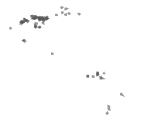

In [ ]:
higher_poly

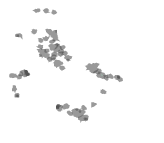

## Creating a GeoDataFrame with two rows

In [10]:
gdf_hl = gpd.GeoDataFrame(['red', 'blue'], geometry=[higher_poly, lower_poly], columns=['color']) #I also added a color column
gdf_hl.crs = 'epsg:4326'

## Initializing the Map and adding the GeoDF

In [11]:
italian_map = folium.Map(location=[itc_lng, itc_lat], zoom_start=6)
folium.GeoJson(data=gdf_hl).add_to(italian_map)
#italian_map #the map later is more embellished, this one works also

## Extra: Setting the color, the style and adding everything to the map

In [12]:
italian_map = folium.Map(location=[itc_lng, itc_lat], zoom_start=6)

In [13]:
#THE STYLE FUNCTION WAS APPLIED AFTER THE LOOP USING THE LAST STYLE IN THE LOOP (I DON'T GET WHY)
#THUS I HAD TO FIX THE DEFAULT VALUE IN THE LAMBDA TO GET IT TO APPLY THEM TO THE CURRENT INSTANCE OF THE LOOP
#I DON'T GET WHY ADDING THE FILL COLOR TO THE DICTIONARY OF THE STYLE I GET FILLED WITH INSTEAD, WHILE KEEPING IT AS DEFAULT WITHOUT ASSIGNING IT, IT GETS APPLYED

gdf_hl = gdf_hl.reset_index(drop=True) #to avoid errors in case I modify the indexing

for n in range(len(gdf_hl)):
    gseries = gpd.GeoSeries(gdf_hl['geometry'][n]) 
    folium.GeoJson(data=gseries.to_json(), 
                    style_function=lambda fillColor=gdf_hl['color'][n], color=gdf_hl['color'][n]: {'color': color}).add_to(italian_map)

## Visualizing the result extra

In [ ]:
italian_map

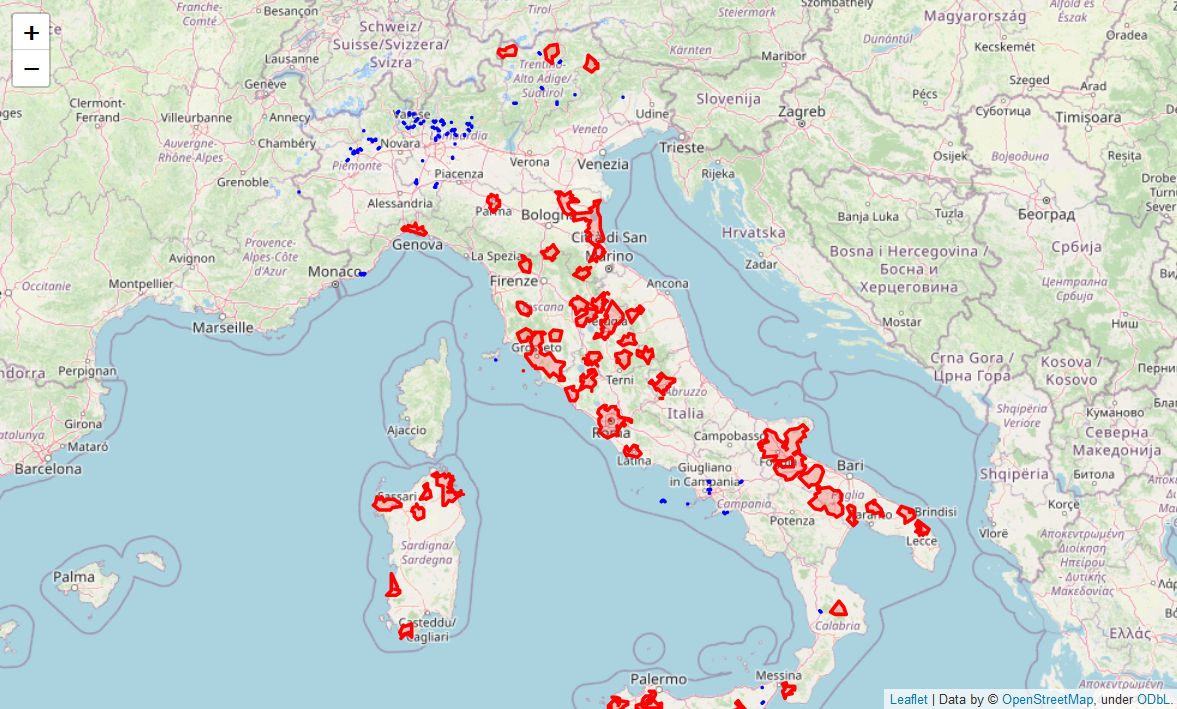